<a href="https://colab.research.google.com/github/alsbhn/City-Satisfiers_in_News/blob/master/City_Satisfiers_in_News_March2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cities and Human Needs Satisfiers in the News

## Introduction
<P> For centuries people have flocked to cities to enjoy the benefits of urban agglomeration. However, the literature on agglomeration theory mostly takes the perspective of firms. Advocating a people-centred agglomeration theory, this project sees cities as elevators to more than economic progress and asks whether fundamental human needs are also better catered for in cities. </P>
<P> The availability of big data and exploring the promising field of data science to add to our understanding of social science have opened up new opportunities to employ new methodologies to study the complexity of social systems. There is a significant amount of textual data on the internet which are being produced every moment all over the world and, surprisingly, this data has remarkable multi-scale geographical details. This text data may reveal information about many objective indicators of satisfiers in cities and can be retrieved through a text mining approach that focuses on words that signal the presence of satisfiers and dissatisfiers of human needs in connection to geographical names that co-occur in the same texts. Such a ‘bag of words’ approach can be also used to analyse subjective feelings of residents, how people expressed their emotion about places in ‘social media’. </P>
<P> To answer this geographical questions, I need to discover levels of semantic relatedness between ‘place names’ (Cities, small towns, rural areas etc.), and a ‘bag of words’ which represents the indicators for human needs satisfiers. These keywords are provided through a literature review. For instance, words like ‘isolation’, ‘loneliness’, ‘friends’, ‘family’, ‘love’, ‘marriage’, ‘partner’, ‘divorce’, ‘separation’, ‘party’, ‘encounter’, ‘meet’ etc. can be used to proxy the ‘close relationship’ indicator that partly captures the human need for ‘affection’. To excavate the relations between place names and satisfiers we need to create a corpus from internet news archives and use natural language processing methods. </P>
<P> The first phase of this project is going to focus on US urban system.</p>

## This Notebook
This notebook includes the initial steps of this project in the following sections:
- **_SECTION 1_**: The introduction of the _MediaCloud_ as the project's database
- **_SECTION 2_**: Crawling and corpus creation
- **_SECTION 3_**: Fltering & cleaning the corpus
- **_SECTION 4_**: Training TF-IDF & Topic Modeling
- **_SECTION 5_**: Training a Word2Vec model

## Seteup prerequisites
### _Mount the Google Drive_

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### _Import Libraries_

In [7]:
# Function to show the progress of loops execution
from IPython.display import HTML, display
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))
out = display(progress(0, 100), display_id=True)

## <font color='red'>SECTION 1.</font>  The introduction of the MediaCloud database
[Media Cloud](https://mediacloud.org) is an open source and open data platform for storing, retrieving, visualizing, and analyzing online news, developed at _MIT Center for Civic Media_ which trackes millions of stories published online. This project has a very handy [python API client](https://github.com/mitmedialab/MediaCloud-API-Client) to crawl news stories from their database. Due to copyright restrictions the actual text of a stories are not available.
<p>Let's have a look at the tools that are provided by MediaCloud and the structure of the data that is availeble out there.</p>

### _importing the libraries_

In [0]:
!pip install mediacloud
import mediacloud.api
import pandas as pd
mc = mediacloud.api.MediaCloud('bdcca348bfe34e9c3695255eabf129ad0c6c74dec6bae62efcaf712d14e63326') # Define the api_key

### _import the list of US city names_

In [0]:
us_cities = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/My_PhD/US Cities/uscities.csv')
us_cities.sort_values(by=['population'], inplace=True, ascending=False)
us_cities = us_cities.reset_index(drop=True)
us_cities = us_cities.loc[:9,'city'] # Let's get the first 10 most populous US cities
us_cities = us_cities.values.tolist()

### _import the list of US media_
- Total number of us national + local media resources in mediacloud is __10,670__ which __10,341__ of those are in English or multilingual
- In this project the focus is on English media that published in US. The id numbers of this set of media have been extracted from MediaCloud's website.

In [0]:
us_media = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/My_PhD/media_list/us_media_modified.csv')
us_media.drop_duplicates(subset ="media_id", 
                     keep = "first", inplace = True)
us_media.sort_values(by=['media_id'],inplace=True, ascending=True)
us_media = us_media.reset_index(drop=True)
us_media_id = us_media.loc [:2,'media_id'] # Let's get the first 3 media resources
us_media_id = us_media_id.values.tolist()

### _Retrieve the list of news in a period of time for a city_

In [0]:
import datetime
start_date = datetime.date(2020,1,30) 
end_date = datetime.date(2020,1,31) # The period of data collection

- Retrieve the list of news in a period of time for given cities and media

In [8]:
story_list = []
for media_id in us_media_id:
    for cities in us_cities:
        story_count = mc.storyCount('\"'+cities +'\"'+ " AND media_id: " + 
                                    str(media_id) , mc.publish_date_query(start_date,end_date))
        stories = mc.storyList('\"'+cities +'\"'+ " AND media_id: " + 
                               str(media_id), mc.publish_date_query(start_date, end_date), rows= 2)
        for i in range(len(stories)):
            stories [i]['city_name'] = cities
        story_list = story_list + stories
        print ("Media:",str(media_id) + ", " + cities + ", Number of stories: " + str(story_count['count']), end = '; ')

Media: 1, New York, Number of stories: 70; Media: 1, Los Angeles, Number of stories: 18; Media: 1, Chicago, Number of stories: 9; Media: 1, Miami, Number of stories: 4; Media: 1, Dallas, Number of stories: 3; Media: 1, Philadelphia, Number of stories: 3; Media: 1, Houston, Number of stories: 3; Media: 1, Washington, Number of stories: 35; Media: 1, Atlanta, Number of stories: 3; Media: 1, Boston, Number of stories: 4; Media: 2, New York, Number of stories: 32; Media: 2, Los Angeles, Number of stories: 14; Media: 2, Chicago, Number of stories: 13; Media: 2, Miami, Number of stories: 7; Media: 2, Dallas, Number of stories: 5; Media: 2, Philadelphia, Number of stories: 3; Media: 2, Houston, Number of stories: 4; Media: 2, Washington, Number of stories: 71; Media: 2, Atlanta, Number of stories: 5; Media: 2, Boston, Number of stories: 9; Media: 3, New York, Number of stories: 3; Media: 3, Los Angeles, Number of stories: 0; Media: 3, Chicago, Number of stories: 0; Media: 3, Miami, Number of 

- As a result story_list is a list of dictionaries
- Information about a single story is available by the unique ID of the news

In [9]:
story = story_list [1]
story_url = story ['url']
print('id: ' , story['stories_id'])
print ('url: ' ,story_url)
print ('city: ',story ['city_name'])
print ('resource: ', story['media_name'])
print ('title: ', story ['title'])
print ('date: ' ,story ['collect_date'])

id:  1509833080
url:  https://www.nytimes.com/2020/01/30/learning/lesson-of-the-day-ready-set-vote-heres-everything-you-need-to-know-for-the-2020-primaries.html
city:  New York
resource:  New York Times
title:  Lesson of the Day: ‘Ready, Set, Vote: Here’s Everything You Need to Know for the 2020 Primaries’
date:  2020-01-30 04:13:07.439250


## <font color='red'>SECTION 2.</font>  Crawling and corpus creation
### _Limits of using the API for Crawling_
- Since there are some limits for the requests for each user (1,000 API calls and 20,000 stories returned in any 7 day period), with the help of backend experts of MediaCloud I created a very big query for all US cities with population of more than 10000 inhabitants (almost 4100 cities or in some cases census districts) in all US English media and for a period of 10 years (2010-2020).
- The outcome of this query is about 140 million stories
- The stories are those urls that contains one or more city names matching, including some of the names that are being written in different forms such as 'saint louis' and 'st. louis'
- The result is stored in number of _*.csv.gz_ files each for a period of one month

### _Importing libraries and data_

In [0]:
import gzip
import csv
import time
from multiprocessing import Pool
from sklearn.utils import shuffle

#from my_functions import crawler

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/My_PhD/delft/delft_2019-12.csv.gz', compression='gzip', error_bad_lines=False)
df = shuffle (df) # shuffle the urls in order to avoid sending many request to a single website in a short time
story_list = df.to_dict(orient = 'records')
print("Total number of stories: ", end='')
print(len(story_list))

Total number of stories: 2669144


### _Crawling and text parsing_
- To parse the text of the news from web pages a handy python library has been used which named: _'newspaper'_ 
- The follwoing function named _crawler_ has been deveoped and stored in 'my_functions.py' to crawl and parse the texts
- In this step all the stories that their url does not work due to restrictions for accessibility to the content outside of the US or the ones that are already removed from the internet and also all the stories that _newspaper_ returnes no text for them will be removed form database (almost half of the stories) 

In [0]:
!pip install newspaper3k
!pip install pyOpenSSL
from newspaper import Article
import newspaper
from OpenSSL import SSL

def crawler(story):
    try:
        article = Article(story['url'])
        article.download()
        article.parse()
    except newspaper.article.ArticleException: # handle url missing
        pass
    except SSL.Error: 
        pass
    except UnicodeError:
        pass
    else:
        story_article = article.text
        if not story_article: # handle text missing
            pass
        else:
            article_text_list = {'stories_id':story['stories_id'],
                                      'title':story['title'],
                                      'url':story['url'],
                                      'text':story_article,
                                      'publish_date':story['publish_date'],
                                      'media_id':story['media_id'],
                                      'media_name':story['media_name'],
                                      'media_url':story['media_url'],
                                     }
            return article_text_list

- To speed uo the crawling a multiprocessing method has been employed
- The results of crawling has been stored in a set of _*.csv.gz_ files

In [0]:
for i in range(0,len(df),30000):
    j = i+30000
    start_time = time.time()
    with Pool (50) as p:
        res = p.map(crawler, story_list[i:j])
    print(str(i) + "to" + str(j) + "--- %s seconds ---" % (time.time() - start_time)+
          " total: " + str(len([i for i in res if i])))
    res_1 = [i for i in res if i]
    df = pd.DataFrame(res_1)
    df.to_csv('/content/drive/My Drive/Colab_Notebooks/My_PhD/data_12_2019.csv.gz', mode='a',index=False,header = False, compression = 'gzip')

## <font color='red'>SECTION 3.</font>  Fltering & cleaning the corpus
- The aim of this section is to filter those news that are definitely referring to city entities and alos those news that reporting something in close relation with city name. In other words, the news that city names are important entities to the entire document (SECTION 4).
- In this notebook two pretrained models developed by _stanford_ and _spacy_ are used to recognize name entities. These two models are not such powerful tools regarding our aim since the spacy model does the NER task just in location level (not city level), and also there is still a significant need for disambiguation for recognizing city names in a list of location names that some names are repetitive in the list or the names that are mutual with the names of other entities.
- One solution could be _entity linking_. To do so, there is a pretrained tools developed by [dbpedi spotlight](https://www.dbpedia-spotlight.org/demo/). Unfortunately, their online api is working for limited number of requests. Although they have a local [docker based model](https://hub.docker.com/r/dbpedia/spotlight-english), due to the large size of the model it is not possible to run this model on my laptop. In addition, _spacy_ has some tools for [entity linking](https://spacy.io/usage/training#entity-linker) but it is still in its beta version and there is no pretrained model for that and it is neccessary to train the model in your own corpus.

### _Mthod of this Notebook_
As the stanford model is so time consuming, in this notebook firstly I used spacy model to find the sentences that contains a location name matching our list and afterwards, only these sentences passed into the stanford model to check whether they are containing a city-name or not. All the news stories that did not have any citiy name regarding our list have been removed from the database.

### _Setup Named Entity Recognition (NER) tools_
- Installing Spacy libraries and running Stanford Corenlp

In [0]:
# Load SpaCy Model
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

In [0]:
# Install stanfordnlp; note that the prefix "!" is not needed if you are running in a terminal
!pip install stanfordnlp
# Import stanfordnlp
import stanfordnlp
# Download the Stanford CoreNLP Java library and unzip it to a ./corenlp folder
!echo "Downloading CoreNLP..."
!wget "http://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip" -O corenlp.zip
!unzip corenlp.zip
!mv ./stanford-corenlp-full-2018-10-05 ./corenlp
# Set the CORENLP_HOME environment variable to point to the installation location
import os
os.environ["CORENLP_HOME"] = "./corenlp"
# Import client module
from stanfordnlp.server import CoreNLPClient
# Construct a CoreNLPClient with some basic annotators, a memory allocation of 16GB, and port number 9001
client = CoreNLPClient(annotators=['tokenize','ssplit', 'pos', 'lemma', 'ner'], memory='16G', threads=8,timeout=90000, endpoint='http://localhost:9001')
print(client)
# Start the background server and wait for some time
# Note that in practice this is totally optional, as by default the server will be started when the first annotation is performed
client.start()
import time; time.sleep(10)
# Print background processes and look for java
!ps -o pid,cmd | grep java
# Shut down the background CoreNLP server ###IF REQUIERED###
#client.stop()

     |████████████████████████████████| 163kB 2.8MB/s 
--2020-03-16 07:52:08--  http://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip [following]
--2020-03-16 07:52:08--  https://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 393239982 (375M) [application/zip]
Saving to: ‘corenlp.zip’

corenlp.zip         100%[===================>] 375.02M  39.3MB/s    in 13s     

2020-03-16 07:52:21 (29.9 MB/s) - ‘corenlp.zip’ saved [393239982/393239982]

Archive:  corenlp.zip
   creating: stanford-corenlp-full-2018-10-05/
  inflating: stanford-corenlp-full-2018-

### _Importing libraries and data_

In [0]:
import re, regex
import pandas as pd
import time

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/My_PhD/database/data_12_2019.csv.gz', compression='gzip', error_bad_lines=False,
                names= ['stories_id','title','url','text','publish_date','media_id','media_name','media_url'])

In [0]:
df_1 = df.iloc[:100000,:] # Let's slice a smaller dataframe for faster testing
n = len(df_1)
df_1 = df_1.drop_duplicates(subset='text', keep="first")
n_dup_rmv = len(df_1)
df_1 ['cities'] = [list() for x in range(len(df_1))] # add a new column for city names
df_1 = df_1.to_dict(orient='record') # convert it to a list of dictionaries
print ("--- Percentage of stories with unique text: %s " % (n_dup_rmv*100/n))


--- Percentage of stories with unique text: 69.749 


In [0]:
cities = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/My_PhD/US Cities/uscities_key.csv',encoding='ISO-8859–1')
cities_1  = cities.iloc [0:100,:] # Let's do analysis just over the first 100 most populous cities
cities_1 = cities_1.to_dict(orient='records')

### _Cleaning the text and parsing city names from it_

In [0]:
start_time = time.time()
i=0
for story in df_1:
  # text cleaning
  story ['text'] = story['text'].replace('!','.')
  story ['text'] = story['text'].replace('?','.')
  story ['text'] = re.sub(r"[^A-Za-z0-9^,.'-]", " ", story ['text'])
  story ['text'] = re.sub(' +',' ', story ['text'])
  # replacing some city names
  story ['text'] = re.sub(r'\b'+'Saint Louis'+ r'\b', "St. Louis" , story['text'])
  story ['text'] = re.sub(r'\b'+'Saint Lucie'+ r'\b', "St. Lucie" , story['text'])

  # Parsing city names
  [story['cities'].append(city['city.1'].lower()) for city in cities_1 if regex.search(r'\b'+str(city['city.1'].lower())+ r'\b', story['text'].lower())]
  story['cities']=list(set(story['cities']))

  i += 1
  out.update(progress(i,len(df_1)))
print("--- %s seconds ---" % (time.time() - start_time))

--- 195.93477034568787 seconds ---


### _Removing stories with city names missing_
- In our database there are some news that are not containing any city name because either city name was appeared in another part of the web pag but the text or are not included in our selection of city names for analysis

In [0]:
df_2 = [story for story in df_1 if story['cities']!=[]] # remove city name missing
print ("--- totla number of stories: %s " % str(len(df_2)))
print ("--- Percentage of stories containing city names: %s " % str(len(df_2)*100/len(df_1)))

--- totla number of stories: 40412 
--- Percentage of stories containing city names: 57.93918192375518 


### _Tokenizing with Stanford Corenlp_
- Using Stanford Corenlp all the news are splited into sentences and tokens

In [0]:
start_time = time.time()
i=0
def sent_tok(sentence):
  t = [t.word for t in sentence.token]
  s = ' '.join([t.word for t in sentence.token])
  sent_token_split.append(t)
  sent_split.append(s)

for story in df_2:
    st_annotated = client.annotate(story['text'],annotators=['ssplit'])
    sent_split = []
    sent_token_split=[]
    [sent_tok(sentence) for sentence in st_annotated.sentence]
  
    story ['sent_list'] = sent_split
    story ['sent_token'] = sent_token_split
    i+=1
    out.update(progress(i,len(df_2)))
print("--- %s seconds ---" % (time.time() - start_time))

--- 501.7079634666443 seconds ---


### _NER with SpaCy_

In [0]:
start_time = time.time()
texts = [df_2[i]['sent_list'] for i in range (len(df_2))]
spacy_ner = []
i = 0
for doc in texts:
  sent_ner = []
  for sent in nlp.pipe (doc, disable=["tagger", "parser"]):
    GPE = [ent.text.lower() for ent in sent.ents if ent.label_ == 'GPE']
    GPE = ' '.join(GPE)
    sent_ner.append(GPE)
  spacy_ner = spacy_ner + [{'city_entity_spacy': sent_ner}]
  #spacy_ner_2.append(sent_ner)
  i+=1
  out.update(progress(i,len(texts)))
i=0
for i in range(len(df_2)):
  df_2[i].update(spacy_ner[i])
  #df_2[i]['city_entity_spacy']=' '.join(df_2[i]['city_entity_spacy'])
  i+=1
  out.update(progress(i,len(df_2)))
print("--- %s seconds ---" % (time.time() - start_time))

--- 2013.6330206394196 seconds ---


#### _Check city names/entities matching & removing entity missing for SpaCy_

In [0]:
# Removing spacy tags for locations if it does not contain city name
i = 0
start_time = time.time()
for story in df_2:
  for city in story['cities']:
    for j in range(len(story['city_entity_spacy'])):
      if city not in story['city_entity_spacy'][j]:
        story['city_entity_spacy'][j]=''
  i+=1
  out.update(progress(i,len(df_2)))
print("--- %s seconds ---" % (time.time() - start_time))

--- 45.162774324417114 seconds ---


In [0]:
# Removing entity missing with SpaCy
df_3 = [story for story in df_2 if ''.join(story['city_entity_spacy'])!=''] # remove city name missing
print ("--- totla number of stories: %s " % str(len(df_3)))
print ("--- Percentage of stories containing city names: %s " % str(len(df_3)*100/len(df_2)))

--- totla number of stories: 16563 
--- Percentage of stories containing city names: 40.985350885875484 


### _NER with Stanford Corenlp_ 

In [0]:
start_time = time.time()
i=0
test = []
for story in df_3:
  st_ner = []
  for sent_index in range(len(story['sent_list'])):
    if story['city_entity_spacy'][sent_index] != '':
      st_annotated = client.annotate(story['sent_list'][sent_index],annotators=['ner'])
      st_ner.append(' '.join([token.word.lower() for token in st_annotated.sentence[0].token if token.ner == 'CITY']))
    else:
      st_ner.append('')
  story['city_entity_st']= st_ner
  i += 1
  out.update(progress(i,len(df_3)))
print("--- %s seconds ---" % (time.time() - start_time))

--- 3426.9532330036163 seconds ---


### _Removing stories with city entity missing_
- Just keep the news that are containing the city entities based in both _spacy_ and _stanford_ models

In [0]:
# Removing entity missing with Spacy and Stanford
df_4 = [story for story in df_3 if ''.join(story['city_entity_st'])!=''] # remove entity name missing
print ("--- totla number of stories: %s " % str(len(df_4)))
print ("--- Percentage of stories containing city names: %s " % str(len(df_4)*100/len(df_3)))

--- totla number of stories: 12475 
--- Percentage of stories containing city names: 75.31848095151844 


In [0]:
pd.DataFrame(df_4).to_csv('/content/drive/My Drive/Colab_Notebooks/My_PhD/new_database.csv.gz',index=False,header = False, compression = 'gzip')

## <font color='red'>SECTION 4.</font>  Training TF-IDF & Topic Modeling

### _Defining the importance of city names to news using TF-IDF_
#### Importing libraries

In [0]:
import pandas as pd
import numpy as np
import time
import re

import gensim
from gensim import corpora
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

In [0]:
 df_4 = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/My_PhD/new_database.csv.gz', compression = 'gzip',
                      names= ['stories_id','title','url','text','publish_date','media_id','media_name','media_url','cities','sent_list',
                              'sent_token','city_entity_spacy','city_entity_st'],converters={'sent_token': eval, 
                                                                                             'sent_list': eval, 
                                                                                             'city_entity_st': eval})
 df_4 = df_4.to_dict(orient='record')

In [0]:
cities = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/My_PhD/US Cities/uscities_key.csv',encoding='ISO-8859–1')
cities_1  = cities.iloc [0:100,:] # Let's do analysis just over the first 100 most populous cities
cities_1 = cities_1.to_dict(orient='records')

#### Cleaning the Texts, Handling the Multiword City Names & Split Tokens in All Documents
- To train models sort of preprocessing have been done on the corpus.
  - Removing Stopwords (such as by, has, where, ...)
  - Lemmatization (training --> train)
  - Stemming (facility --> facil)

In [5]:
import string

import itertools
flatten = itertools.chain.from_iterable

import spacy
spacy_nlp = spacy.load('en_core_web_sm')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS # Get the list of stop words from NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk_stopwords = stopwords.words('english') # Get the list of stop words from NLTK
print('Number of stop words: %d' % len(spacy_stopwords))
print('Number of stop words: %d' % len(nltk_stopwords))

stop_words = list (set(list(string.ascii_lowercase) + list(spacy_stopwords) + nltk_stopwords))
print('Number of stop words: %d' % len(stop_words))
print('list of stop words: %s'% stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Number of stop words: 326
Number of stop words: 179
Number of stop words: 400
list of stop words: ['now', 'everywhere', 'down', 'could', 'whole', 'having', 'can', 'get', 'may', 'otherwise', 'without', 'thus', 'nine', 'give', 'per', 'hereby', "weren't", 'another', "she's", 're', 'each', 'due', 'we', 'that', 'yet', "shan't", 'amount', 'b', 'did', 'them', 'c', 'two', 'besides', 'himself', 'nowhere', 'wherever', "isn't", 'other', 'whence', 'anyhow', 'l', 'must', 'anyway', 'do', '’d', 'move', 'ourselves', 'hence', 'toward', "didn't", 'own', 'above', 'please', 'those', "won't", "haven't", 'these', 'any', 'five', 'somehow', "couldn't", 'it', 'whoever', 'fifteen', 'no', 'therein', 'along', 'a', 'amongst', 'various', 'latter', '‘re', 'none', 'really', 'over', 'they', 'shan', 'indeed', 'seems', 'than', 'except', '‘ll', 'its', 'he', 'put', 'i', 'top', 'several', 'won', 'why', 'is

In [8]:
start_time = time.time()
j = 0
new_texts_token = []
new_texts_sent_token=[]
for story in df_4:
  new_text = []
  for i in range(len(story['sent_list'])):
    new_sent = story['sent_list'][i].replace('.',' ')
    new_sent = new_sent.replace(',',' ')
    new_sent = new_sent.lower()
    new_sent = re.sub(' +',' ', new_sent)
    if story['city_entity_st'][i] != '':
      for city in cities_1:
        name = r'\b'+ city['city.2'].lower()+ r'\b'
        new_sent = re.sub(name, str(city['city.2'].replace(" ", "_").lower()) + "$", new_sent, flags=re.IGNORECASE)
    new_sent = [token for token in new_sent.split() if token not in stop_words] # stop words
    new_sent = [x for x in new_sent if not any(c.isdigit() for c in x)] # remove tokens including numbers
    new_text.append(' '.join(new_sent))

  new_text_2=[]
  for sent in spacy_nlp.pipe (new_text, disable=["ner", "parser"]):
    new_sent = [x.lemma_ for x in sent]                         #Lemmatization with spacy
    new_sent = [stemmer.stem(token) for token in new_sent]      #Stemming with nltk
    new_text_2.append(new_sent)
  
  new_texts_token.append(list(flatten(new_text_2)))
  new_texts_sent_token.append(new_text_2)
  j+=1
  out.update(progress(j,len(df_4)))
print("--- %s seconds ---" % (time.time() - start_time))

--- 400.770382642746 seconds ---


In [9]:
i=0
for i in range(len(df_4)):
  df_4[i].update(text_token = new_texts_token[i])
  df_4[i].update(text_sent_token = new_texts_sent_token[i])
  i+=1
  out.update(progress(i,len(df_4)))
print("--- %s seconds ---" % (time.time() - start_time))


--- 470.1700620651245 seconds ---


In [10]:
print(df_4[0]['text'])
print(df_4[0]['text_token'])
print(df_4[0]['text_sent_token'])

SAN DIEGO Parole was recommended Tuesday for a one-time champion skateboarder who has spent nearly three decades in prison for raping and killing a woman at his Southern California home. A parole board made the recommendation for Mark Gator Rogowski, 53, during a hearing at the Richard J. Donovan Correctional Facility in San Diego, KGTV-TV reported. Rogowski confessed to killing 22-year-old Jessica Bergsten in 1991 at his Carlsbad home. He beat her with a car lock, chained her to a bed, raped her, then placed her in a surfboard bag and strangled her before burying her in the desert, authorities said. Bergsten was a friend of Rogowski s former girlfriend and he said he attacked her out of misplaced revenge after he was dumped. CLICK HERE if you are having a problem viewing the video on a mobile device Rogowski pleaded guilty to rape and murder and was sentenced to 31 years in prison. He lost bids for parole in 2011 and 2016. I m disgusted with what I did. I think about it every day, the

#### Training TF-IDF with gensim

In [11]:
# Make a dictionary form words in the corpus
dictionary = corpora.Dictionary([story['text_token'] for story in df_4])
print ("--- Number of words in dictionary: %s " % len(dictionary))

--- Number of words in dictionary: 71484 


In [0]:
corpus = [dictionary.doc2bow(story['text_token']) for story in df_4]  # convert corpus to BoW format
tfidf = TfidfModel(corpus)  # fit model

In [13]:
# Calculate tfidf weights of words in texts
start_time = time.time()
for i in range(len(tfidf[corpus])):
  df_4 [i].update(tfidf_weights = [[dictionary[id], np.around(freq, decimals=2)] for id, freq in tfidf[corpus][i]])
print("--- %s seconds ---" % (time.time() - start_time))

--- 28.773566961288452 seconds ---


In [0]:
# add wights of citie to dataset
cities = [str(city['city.2'].replace(' ', '_').lower())+"$" for city in cities_1]
for story in df_4:
  for word in story ['tfidf_weights']:
    if word[0] in cities:
      name= word[0]
      val = word[1]
      d= {name: val}
      story.update(d)

Results

In [15]:
# Return important news of each city
city = 'los_angeles$'
top_news = pd.DataFrame(df_4).nlargest(20,city).loc[:,['stories_id','text',city, 'url']]
for i in range (len(top_news)):
  print("{}- {} -- weight {} -- url: {} -- text: {} ".format((i+1),top_news.iloc[i,0],top_news.iloc[i,2], top_news.iloc[i,3], top_news.iloc[i,1]))

1- 1479486783 -- weight 0.49 -- url: https://www.pe.com/2019/12/25/clippers-win-christmas-day-clash-as-lakers-lose-4th-in-a-row/ -- text: Los Angeles Lakers LeBron James, left, and Los Angeles Clippers Kawhi Leonard 2 chase the ball during the second half of an NBA basketball game Wednesday, Dec. 25, 2019, in Los Angeles. The Clippers won 111-106. AP Photo Ringo H.W. Chiu Los Angeles Lakers LeBron James 23 and Los Angeles Clippers Kawhi Leonard 2 chase the ball during an NBA basketball game between Los Angeles Lakers and Los Angeles Clippers, Wednesday, Dec. 25, 2019, in Los Angeles. The Clippers won 111-106. AP Photo Ringo H.W. Chiu Sound The gallery will resume in seconds Los Angeles Lakers LeBron James 23 and Los Angeles Clippers Kawhi Leonard 2 chase the ball during an NBA basketball game between Los Angeles Lakers and Los Angeles Clippers, Wednesday, Dec. 25, 2019, in Los Angeles. The Clippers won 111-106. AP Photo Ringo H.W. Chiu Los Angeles Lakers LeBron James 23 and Los Angeles

### _Applying a Topic Modeling_
#### LDA Method

In [16]:
!pip install https://github.com/clips/pattern/archive/python3.zip
from gensim.models import LdaModel, LdaMulticore
from gensim.utils import simple_preprocess, lemmatize

import re
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
logging.root.setLevel(level=logging.INFO)

     / 32.5MB 216kB/s
     |████████████████████████████████| 92kB 2.7MB/s 
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [17]:
# Create the Inputs of LDA model: Dictionary and Corpus
dictionary = corpora.Dictionary([story['text_token'] for story in df_4])
corpus = [dictionary.doc2bow(line) for line in [story['text_token'] for story in df_4]]

2020-03-23 10:36:36,217 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-03-23 10:36:38,788 : INFO : adding document #10000 to Dictionary(63996 unique tokens: ['-', 'angri', 'attack', 'attorney', 'author']...)
2020-03-23 10:36:39,438 : INFO : built Dictionary(71484 unique tokens: ['-', 'angri', 'attack', 'attorney', 'author']...) from 12475 documents (total 3456002 corpus positions)


In [19]:
# Train the LDA model
lda_model = LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         random_state=100,
                         num_topics=20,
                         passes=10,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)

2020-03-23 10:37:15,856 : INFO : using asymmetric alpha [0.12456869, 0.10180451, 0.08607485, 0.07455541, 0.06575534, 0.05881336, 0.053197186, 0.048560105, 0.044666618, 0.041351136, 0.038493842, 0.0360059, 0.03382003, 0.031884372, 0.030158294, 0.028609501, 0.027212018, 0.0259447, 0.024790173, 0.023734018]
2020-03-23 10:37:15,857 : INFO : using symmetric eta at 0.05
2020-03-23 10:37:15,872 : INFO : using serial LDA version on this node
2020-03-23 10:37:16,079 : INFO : running online LDA training, 20 topics, 10 passes over the supplied corpus of 12475 documents, updating every 3000 documents, evaluating every ~0 documents, iterating 100x with a convergence threshold of 0.001000
2020-03-23 10:37:16,081 : INFO : training LDA model using 3 processes
2020-03-23 10:37:16,167 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #1000/12475, outstanding queue size 1
2020-03-23 10:37:16,484 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #2000/12475, outstanding queue

In [20]:
lda_model.print_topics(-1)

2020-03-23 10:41:02,604 : INFO : topic #0 (0.125): 0.025*"afghanistan" + 0.015*"afghan" + 0.012*"taliban" + 0.009*"karzai" + 0.008*"say" + 0.007*"govern" + 0.006*"corrupt" + 0.006*"peac" + 0.005*"drake" + 0.005*"offici"
2020-03-23 10:41:02,607 : INFO : topic #1 (0.102): 0.015*"say" + 0.011*"-" + 0.011*"court" + 0.007*"case" + 0.007*"state" + 0.006*"law" + 0.006*"trump" + 0.005*"attorney" + 0.005*"feder" + 0.005*"judg"
2020-03-23 10:41:02,611 : INFO : topic #2 (0.086): 0.026*"say" + 0.017*"polic" + 0.011*"offic" + 0.011*"-" + 0.008*"counti" + 0.008*"report" + 0.007*"man" + 0.007*"citi" + 0.006*"shoot" + 0.006*"accord"
2020-03-23 10:41:02,613 : INFO : topic #3 (0.075): 0.017*"-" + 0.008*"navi" + 0.007*"dec" + 0.007*"ufc" + 0.006*"fight" + 0.006*"funer" + 0.005*"date" + 0.005*"armi" + 0.004*"photo" + 0.004*"church"
2020-03-23 10:41:02,616 : INFO : topic #4 (0.066): 0.028*"las_vegas$" + 0.020*"cruis" + 0.018*"port" + 0.013*"sr" + 0.013*"ship" + 0.011*"journal" + 0.011*"elizabeth" + 0.011*"

[(0,
  '0.025*"afghanistan" + 0.015*"afghan" + 0.012*"taliban" + 0.009*"karzai" + 0.008*"say" + 0.007*"govern" + 0.006*"corrupt" + 0.006*"peac" + 0.005*"drake" + 0.005*"offici"'),
 (1,
  '0.015*"say" + 0.011*"-" + 0.011*"court" + 0.007*"case" + 0.007*"state" + 0.006*"law" + 0.006*"trump" + 0.005*"attorney" + 0.005*"feder" + 0.005*"judg"'),
 (2,
  '0.026*"say" + 0.017*"polic" + 0.011*"offic" + 0.011*"-" + 0.008*"counti" + 0.008*"report" + 0.007*"man" + 0.007*"citi" + 0.006*"shoot" + 0.006*"accord"'),
 (3,
  '0.017*"-" + 0.008*"navi" + 0.007*"dec" + 0.007*"ufc" + 0.006*"fight" + 0.006*"funer" + 0.005*"date" + 0.005*"armi" + 0.004*"photo" + 0.004*"church"'),
 (4,
  '0.028*"las_vegas$" + 0.020*"cruis" + 0.018*"port" + 0.013*"sr" + 0.013*"ship" + 0.011*"journal" + 0.011*"elizabeth" + 0.011*"brumley" + 0.010*"fisher" + 0.010*"review"'),
 (5,
  '0.011*"plant" + 0.011*"lng" + 0.010*"shark" + 0.007*"beethoven" + 0.007*"kinder" + 0.006*"imus" + 0.005*"morgan" + 0.005*"ping" + 0.005*"poison" + 0.

#### LSI Method

In [22]:
from gensim.models import LsiModel

# Build the LSI Model
lsi_model = LsiModel(corpus=corpus, id2word=dictionary, num_topics=100, decay=0.5)

2020-03-23 10:41:35,406 : INFO : using serial LSI version on this node
2020-03-23 10:41:35,408 : INFO : updating model with new documents
2020-03-23 10:41:35,414 : INFO : preparing a new chunk of documents
2020-03-23 10:41:35,991 : INFO : using 100 extra samples and 2 power iterations
2020-03-23 10:41:36,048 : INFO : 1st phase: constructing (71484, 200) action matrix
2020-03-23 10:41:36,751 : INFO : orthonormalizing (71484, 200) action matrix
2020-03-23 10:41:42,740 : INFO : 2nd phase: running dense svd on (200, 12475) matrix
2020-03-23 10:41:43,226 : INFO : computing the final decomposition
2020-03-23 10:41:43,228 : INFO : keeping 100 factors (discarding 11.182% of energy spectrum)
2020-03-23 10:41:43,392 : INFO : processed documents up to #12475
2020-03-23 10:41:43,400 : INFO : topic #0(1747.357): 0.849*"-" + 0.185*"say" + 0.178*"imag" + 0.159*"data" + 0.105*"dec" + 0.100*"year" + 0.090*"los_angeles$" + 0.062*"time" + 0.059*"state" + 0.059*"like"
2020-03-23 10:41:43,407 : INFO : topi

In [23]:
# View Topics
print(lsi_model.print_topics(-1))

2020-03-23 10:41:47,677 : INFO : topic #0(1747.357): 0.849*"-" + 0.185*"say" + 0.178*"imag" + 0.159*"data" + 0.105*"dec" + 0.100*"year" + 0.090*"los_angeles$" + 0.062*"time" + 0.059*"state" + 0.059*"like"
2020-03-23 10:41:47,687 : INFO : topic #1(1163.976): 0.688*"los_angeles$" + 0.303*"clipper" + 0.247*"laker" + 0.211*"user" + 0.178*"photo" + 0.175*"game" + 0.153*"decemb" + 0.148*"getti" + -0.133*"-" + 0.113*"imag"
2020-03-23 10:41:47,695 : INFO : topic #2(978.905): -0.538*"say" + 0.326*"-" + 0.227*"data" + 0.209*"imag" + -0.166*"year" + -0.125*"state" + -0.114*"peopl" + -0.108*"citi" + -0.107*"time" + -0.096*"work"
2020-03-23 10:41:47,701 : INFO : topic #3(495.654): 0.428*"say" + -0.293*"game" + -0.210*"team" + 0.196*"imag" + 0.189*"data" + 0.176*"polic" + -0.170*"season" + -0.165*"play" + -0.148*"point" + -0.141*"year"
2020-03-23 10:41:47,708 : INFO : topic #4(433.667): 0.382*"say" + 0.228*"game" + -0.188*"citi" + -0.183*"hous" + 0.173*"polic" + -0.159*"new" + -0.146*"year" + 0.133*

[(0, '0.849*"-" + 0.185*"say" + 0.178*"imag" + 0.159*"data" + 0.105*"dec" + 0.100*"year" + 0.090*"los_angeles$" + 0.062*"time" + 0.059*"state" + 0.059*"like"'), (1, '0.688*"los_angeles$" + 0.303*"clipper" + 0.247*"laker" + 0.211*"user" + 0.178*"photo" + 0.175*"game" + 0.153*"decemb" + 0.148*"getti" + -0.133*"-" + 0.113*"imag"'), (2, '-0.538*"say" + 0.326*"-" + 0.227*"data" + 0.209*"imag" + -0.166*"year" + -0.125*"state" + -0.114*"peopl" + -0.108*"citi" + -0.107*"time" + -0.096*"work"'), (3, '0.428*"say" + -0.293*"game" + -0.210*"team" + 0.196*"imag" + 0.189*"data" + 0.176*"polic" + -0.170*"season" + -0.165*"play" + -0.148*"point" + -0.141*"year"'), (4, '0.382*"say" + 0.228*"game" + -0.188*"citi" + -0.183*"hous" + 0.173*"polic" + -0.159*"new" + -0.146*"year" + 0.133*"play" + -0.124*"state" + 0.122*"team"'), (5, '-0.698*"vs" + -0.355*"record" + -0.349*"rate" + -0.341*"sagarin" + -0.142*"state" + 0.089*"like" + -0.071*"polic" + -0.071*"citi" + 0.063*"know" + -0.059*"offic"'), (6, '0.364*"

## <font color='red'>SECTION 4.</font>  Training a Word2Vec model
### _Import Libraries_

In [25]:
import gensim
from gensim.models import Word2Vec
import json
import pandas as pd
import nltk
nltk.download('punkt')
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
import numpy as np

# Get the interactive Tools for Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Display scatterplot with pca
def display_pca_scatterplot(model, words_1=None,words_2 = None, sample=0):
    if words_1 == None:
        if sample > 0:
            words_1 = model.vocabulary.sample(sample)
        else:
            words_1 = [ word for word in model.vocab ]
    words = words_1 + words_2    
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(17,17))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        if word in words_1:
          plt.text(x+0.05, y+0.05, word,c='r')
        else:
          plt.text(x+0.05, y+0.05, word,c='b')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Convert data to compatible input format for trainig the W2V model

In [0]:
article_tokenized = []
for story in df_4:
  for sent in story['text_sent_token']:
    article_tokenized.append(sent)

### _Training the model_

In [27]:
model = Word2Vec(article_tokenized, min_count=1,size= 50,workers=3, window =3, sg = 1)

2020-03-23 10:46:31,315 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-03-23 10:46:31,318 : INFO : collecting all words and their counts
2020-03-23 10:46:31,319 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-03-23 10:46:31,352 : INFO : PROGRESS: at sentence #10000, processed 111240 words, keeping 11954 word types
2020-03-23 10:46:31,380 : INFO : PROGRESS: at sentence #20000, processed 224152 words, keeping 17718 word types
2020-03-23 10:46:31,409 : INFO : PROGRESS: at sentence #30000, processed 334750 words, keeping 21670 word types
2020-03-23 10:46:31,439 : INFO : PROGRESS: at sentence #40000, processed 440076 words, keeping 25171 word types
2020-03-23 10:46:31,470 : INFO : PROGRESS: at sentence #50000, processed 551518 words, keeping 28253 word types
2020-03-23 10:46:31,501 : INFO : PROGRESS: at sentence #60000, processed 657725 words, keeping 30778 word types
2020-03-23 10:46:31,534 : INFO : PROGRESS: at sente

**Similarity of words**

In [29]:
model.most_similar('new_york$')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-03-23 10:47:45,102 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('wabc', 0.8076508641242981),
 ('boston$', 0.7865062952041626),
 ('chicago$', 0.7830195426940918),
 ('monsey', 0.7733372449874878),
 ('philadelphia$', 0.7657303810119629),
 ('hattiesburg', 0.7635786533355713),
 ('bronx$', 0.762633740901947),
 ('brooklyn$', 0.7617875337600708),
 ('berlin', 0.760088324546814),
 ('borough', 0.7540232539176941)]

**Analogy**

In [0]:
def analogy(x1, x2, y1):
    result = model.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [36]:
analogy('detroit$', 'crime', 'boston$')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'violenc'

### _Visualizing in 2D_

In [0]:
city_names = []
for city in cities_1:
  c = city['city.2'].replace(' ','_').lower()
  c = c+ "$"
  city_names.append(c)

In [0]:
satisfiers = ['crime', 'kidnap','violent','crimin', 'violenc', 'homeless','shelter','hous','renter',
              'freedom','democraci','extremist','radic','authoritarian','ideolog']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


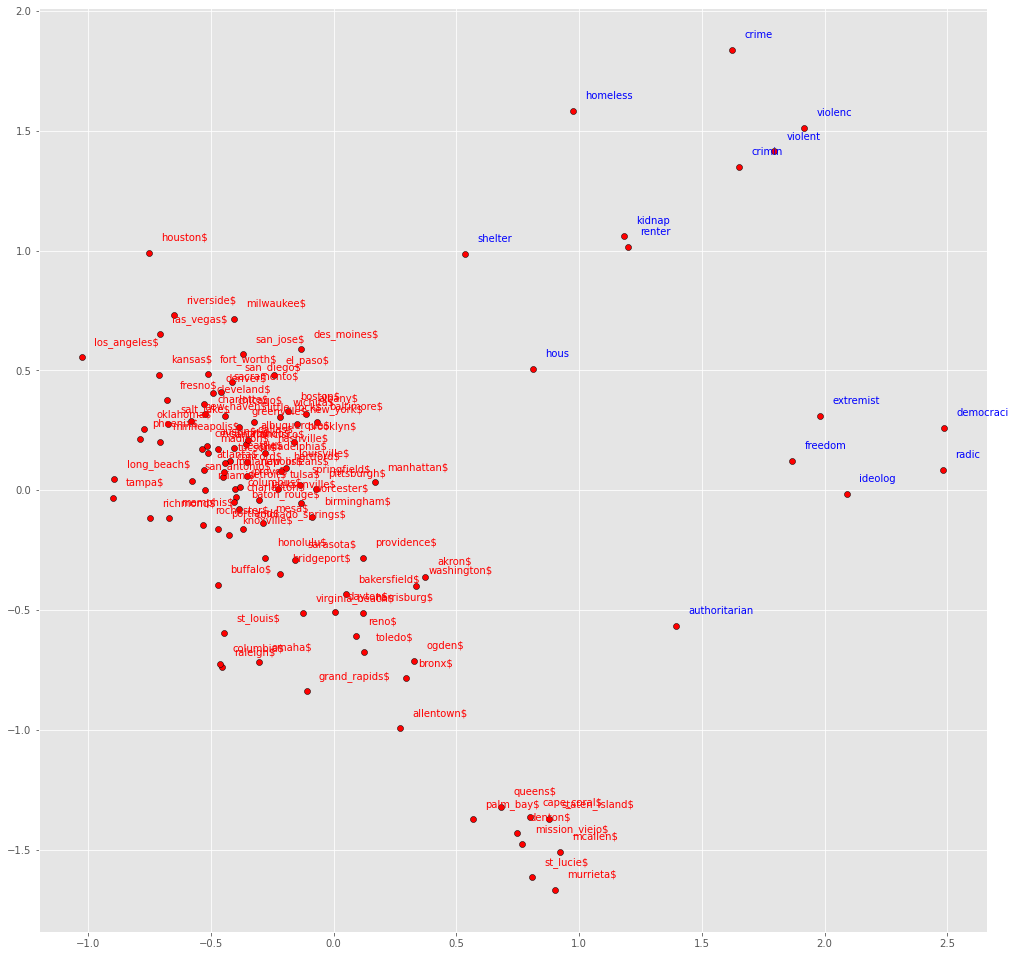

In [39]:
display_pca_scatterplot(model, city_names , satisfiers)

### Similarity of city names to a set of words

In [40]:
similarity_1=[]
similarity_2=[]
similarity_3=[]
similarity_4=[]

for city in city_names:
  similarity_1.append(model.similarity('crime',city))
  similarity_2.append(model.similarity('rape',city))
  similarity_3.append( model.similarity('kidnap',city))
  similarity_4.append(model.similarity('violent',city))

  #print ("-- {} : crime: {} -- rape: {} -- kidnap: {} -- violent: {} ".format(city,similarity_1,similarity_2,similarity_3,similarity_4))
sim_ranks = pd.DataFrame({'city': city_names, 'crime': similarity_1, 'rape': similarity_2, 'kidnap': similarity_3, 'violent': similarity_4})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Me

In [41]:
sim_ranks['crime'] = sim_ranks.apply (lambda row: row.crime/sim_ranks.crime.values.max(), axis=1)
sim_ranks['rape'] = sim_ranks.apply (lambda row: row.rape/sim_ranks.rape.values.max(), axis=1)
sim_ranks.sort_values(by='rape', ascending=False).iloc[50:100,:]

,city,crime,rape,kidnap,violent
10,phoenix$,0.673692,0.739583,0.523593,0.393208
66,allentown$,0.640466,0.734415,0.452878,0.404523
17,denver$,0.872604,0.732453,0.449749,0.567249
67,tulsa$,0.857764,0.731191,0.507489,0.560615
83,provo$,0.702093,0.731064,0.472044,0.418127
29,cleveland$,0.856614,0.730668,0.492614,0.517451
19,queens$,0.703113,0.729449,0.498515,0.485086
97,madison$,0.643499,0.724696,0.466470,0.433264
38,charlotte$,0.878604,0.724389,0.520314,0.498590
42,jacksonville$,0.855159,0.723811,0.530115,0.542119


### Similarity of city names to a set of words

In [42]:
similarity=[]
for city in city_names:
  similarity.append(model.n_similarity(list(city.split()),['crime','kidnap','crimin','violent','homicid','violenc']))

  #print ("-- {} : crime: {} -- rape: {} -- kidnap: {} -- violent: {} ".format(city,similarity_1,similarity_2,similarity_3,similarity_4))
sim_ranks = pd.DataFrame({'city': city_names, 'crime_set': similarity})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [43]:
sim_ranks['crime_set'] = sim_ranks.apply (lambda row: row.crime_set/sim_ranks.crime_set.values.max(), axis=1)
sim_ranks.sort_values(by='crime_set', ascending=False).iloc[50:100,:]

,city,crime_set
39,bronx$,0.776361
61,birmingham$,0.774044
13,detroit$,0.769311
97,madison$,0.762716
41,providence$,0.760945
27,san_jose$,0.758837
76,knoxville$,0.758294
8,atlanta$,0.756430
15,minneapolis$,0.752152
34,kansas$,0.749511


### _An idea for retrofitting city name vectors_
- Here I tried to subtract the city name vectors and the mean vector of other cities to remove the mutual semantic of the cities to excavate the specifity of each city name in the space

In [44]:
city_vectors = []
for city in city_names:
  item = {}
  item ['city'] = city
  item ['vec'] = model[city]
  city_vectors.append(item)
#city_vectors = np.array(city_vectors) #convert to numpy format
#city_mean_v = np.mean(city_vectors, axis=0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [0]:
for item in city_vectors:
  other_city_vec = np.array([x['vec'] for x in city_vectors if x['city'] != item['city']]) #convert to numpy format
  city_mean_v = np.mean(other_city_vec, axis=0)
  item['new_vec'] = np.sum(np.array([item['vec'],np.negative(city_mean_v)]),axis=0)

Cosin similarity using numpy

In [47]:
similarity=[]
for i in range (len(city_names)):
  #similarity.append(model.n_similarity(list(city.split()),['crime','kidnap','crimin','violent','homicid','violenc']))
  a= city_vectors[i]['new_vec']
  b= model['rape']
  similarity.append(dot(a, b)/(norm(a)*norm(b)))
  #print ("-- {} : crime: {} -- rape: {} -- kidnap: {} -- violent: {} ".format(city,similarity_1,similarity_2,similarity_3,similarity_4))
sim_ranks = pd.DataFrame({'city': city_names, 'sat': similarity})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [48]:
#sim_ranks['crime_set'] = sim_ranks.apply (lambda row: row.crime_set/sim_ranks.crime_set.values.max(), axis=1)
sim_ranks.sort_values(by='sat', ascending=False).iloc[0:50,:]

,city,sat
54,fort_worth$,0.440869
90,des_moines$,0.410500
21,riverside$,0.395194
80,new_haven$,0.387429
56,el_paso$,0.381924
44,nashville$,0.334691
89,wichita$,0.317082
33,austin$,0.286933
27,san_jose$,0.279655
5,philadelphia$,0.272920
